# library and funcs

In [1]:
from datetime import datetime, timedelta
import numpy as np


import geopandas as gpd
import rasterio
from osgeo import gdal, osr
import pandas as pd
import zipfile
import os
import glob

from affine import Affine
from pyproj import Proj, transform
import pyproj

from matplotlib import pyplot as plt

from geopy.distance import geodesic

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
import keras
from keras.layers import Dense, Activation, Flatten, Conv2D, Convolution2D, Dropout, MaxPooling2D, MaxPool2D
from tensorflow.keras.optimizers import SGD, Adadelta, Adagrad, Adam
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model
from keras.wrappers.scikit_learn import KerasRegressor
from scipy import  interpolate
import mpl_toolkits.mplot3d
import matplotlib.pyplot as plt
import folium
import seaborn as sns

from scipy import ndimage as nd
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import cv2
import json
import joblib
import requests
import json
from pandas.io.json import json_normalize
from scipy.interpolate import griddata

import pickle
import imutils


C:\Users\xurui\AppData\Roaming\Python\Python38\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
def mean(num):
    m = 0
    try:
        m = sum(num)/len(num)
    except:
        pass
    return round(m,2)

# read all csv files from zip files and slice
def get_save_csv(inp_dir, output_dir, vari, year):
    zip_file_name = f'hourly_{str(vari)}_{str(year)}.zip'
    csv_file_name = f'hourly_{str(vari)}_{str(year)}.csv'
    zf = zipfile.ZipFile(os.path.join(inp_dir, zip_file_name))
    #zf.extract(csv_file_name, output_dir)
    print('Start reading ' + csv_file_name)
    df = pd.read_csv(zf.open(csv_file_name))
    print('Read '+ csv_file_name)
    return df

def get_epa_of_this_year(year, inp_dir, output_dir):
    for i in list_v:
        path_df = os.path.join(output_dir,f'hourly_{str(i)}_{str(year)}_m.csv')
        if os.path.exists(path_df):
            print(path_df, ' exists.')
        else:
            df = get_save_csv(inp_dir, output_dir, str(i), str(year))
            print('Process '+ i )
            dftmp = df[(df['Latitude']<40)&((df['County Name'] == 'Riverside')|(df['County Name'] == 'Imperial'))] # (df['State Name']=='California')]
            dftmp2 = dftmp[['Site Num', 'Date Local', 'Latitude', 'Longitude']].drop_duplicates()
            dftmp2['AvgValue'] = 0
            show_process = 0.00005
            for n in range(len(dftmp2)):
                dftmp2.iloc[n, -1] = mean(dftmp[(dftmp['Date Local']==dftmp2.iloc[n, 1])
                                                &(dftmp['Latitude']==dftmp2.iloc[n, 2])
                                                &(dftmp['Longitude']==dftmp2.iloc[n, 3])
                                                &(dftmp['Time GMT']<= '20:00')&(dftmp['Time GMT']>='17:00')]['Sample Measurement'])
                if n/len(dftmp2)>show_process/100:
                    print(str(int(show_process))+'%', end = ' ')
                    show_process +=5
            dftmp2.reset_index(drop=True).to_csv(path_df, index=False)
            print()


#%%
# pre-

def out_date(year,day):
    fir_day = datetime(int(year),1,1)
    zone = timedelta(days=day-1)
    return datetime.strftime(fir_day + zone, "%Y-%m-%d")


def read_tif(img_dir):
    ds = rasterio.open(img_dir)
    T0 = ds.transform
    p1 = Proj(ds.crs)
    r = ds.read()[0] # so the shape will be [row, col], not [1, row, col]
    cols, rows = np.meshgrid(np.arange(r.shape[1]), np.arange(r.shape[0]))
    T1 = T0 * Affine.translation(0.5, 0.5)
    rc2en = lambda r, c: T1 * (c, r)
    eastings, northings = np.vectorize(rc2en, otypes=[np.float, np.float])(rows, cols)
    p2 = Proj(proj='latlong',datum='WGS84')
    longs, lats = transform(p1, p2, eastings, northings)
    return r, lats, longs

def get_rowcol(lats, longs, lat, long, n=3): 
    # get several (n=3) nearest point to the input lat&long
    # calculate the distance between input point and selected near point
    # return the nearest one
    lat_precision = 0.05
    lon_precision = 0.05
    l1 = []
    l2 = []
    while len(l1)<n or len(l2)<n: # not find enough lat or long
        lon_array = np.where((longs > long-lon_precision) & (longs < long+lon_precision))
        lat_array = np.where((lats > lat-lat_precision) & (lats < lat+lat_precision))

        l1 = np.unique([i for i in lon_array[0] if i in lat_array[0]])
        l2 = np.unique([i for i in lon_array[1] if i in lat_array[1]])
        if len(l1)<n:
            lat_precision += 0.01
        else:
            pass
        if len(l2)<n:
            lon_precision += 0.01
        else:
            pass
    dist = float('inf')
    for i in l1: #760
        for j in l2: #1539
            dist_ = geodesic((lats[i,j], longs[i,j]), (lat, long)).km
            if dist_ < dist:
                row, col = i, j
                dist = dist_
            else:
                pass
    return int(row), int(col)


def get_loc_relation(df, input_f): 
    # get the lats&longs from df and find the nearest one for every point
    # return as dict
    r, lats, longs = read_tif(input_f)
    dftmp = df[['Latitude', 'Longitude']].drop_duplicates().reset_index(drop = True)
    dftmp['row'] = np.nan
    dftmp['col'] = np.nan
    dict_rel_point = {}
    for i in range(len(dftmp)):
        lat = dftmp.loc[i, 'Latitude']
        long = dftmp.loc[i, 'Longitude']
        key = str(str(round(lat,4))+' '+str(round(long, 4)))
        row, col = get_rowcol(lats, longs, lat, long)
        dict_rel_point[key] = [row, col]
    return dict_rel_point

def get_values(r, row, col, pixels = 3):
    a = r[row-1:row+2, col-1:col+2] # 3*3 pixels
    b = r[row-2:row+3, col-2:col+3] # 5*5 pixels
    c = r[row, col] # 1 pixel
    a_v = np.mean(np.where(a<0, 0, a))
    b_v = np.mean(np.where(b<0, 0, b))
    if pixels == 3:
        return a_v
    elif pixels == 5:
        return b_v
    else:
        return c

#%% 
# extract value from modis tif files. based on the lat and long 
def extract_all(df, year): # extract aod, lu, ndvi for one year. for full raster not cropped raster
    # land cover
    lu_mcd12 = os.path.join(modis_path, 'mcd12')
    lu = glob.glob(lu_mcd12+'\*.tif')
    print('Start LU.')
    df['LU'] = np.nan
    if str(year) == '2020'or'2021':
        lu_y = [i for i in lu if '2019' == i.split('.h08v05.')[0][-7:-3]][0]
    else:
        lu_y = [i for i in lu if str(year) == i.split('.h08v05.')[0][-7:-3]][0]
    r, lats, longs = read_tif(lu_y)
    dftmp = df[['Latitude', 'Longitude']].drop_duplicates().reset_index(drop=True)
    for i in range(len(dftmp)):
        lat,long = dftmp.loc[i]
        key = str(str(round(lat,4))+' '+str(round(long, 4)))
        try:
            row,col = lu_d[key]
        except:
            row,col = get_rowcol(lats, longs, lat, long)
            aod_d[key]=[row,col]
        value = get_values(r, row, col, pixels = 1) # pixels = 1 for the land use type is not int, it should be str/obj
        df.loc[(df['Latitude']==lat)&(df['Longitude']==long), ['LU']] = str(value)
        #print(value,df.loc[(df['Latitude']==lat)&(df['Longitude']==long), ['LU']].values[0], row,col, end = '  \  ')
    print('\nLU done.')

    # path of NDVI
    NDVI_mod13 = 'D:\MSDA\data298\MODIS\mod13a2'
    ndvi = glob.glob(NDVI_mod13+'\*.tif')
    ndvi = [i for i in ndvi if str(year) == i.split('.h08v05.')[0][-7:-3] or (str(year+1)==i.split('.h08v05.')[0][-7:-3] and int(i.split('.h08v05.')[0][-3:])<15)]
    df['NDVI'] = np.nan
    dftmp = df[['Latitude', 'Longitude']].drop_duplicates().reset_index(drop=True)
    print('NDVI ')
    for i in ndvi:
        date = i.split('.h08v05.')[0][-7:]
        print(date, end=':')
        t1 = out_date(int(year), int(date[4:])-8)
        t2 = out_date(int(year), int(date[4:])+8)
        r, lats, longs = read_tif(i)
        for j in range(len(dftmp)):
            print(round(j/len(dftmp)*100), '%', end = ' ')
            lat = dftmp['Latitude'][j]
            long = dftmp['Longitude'][j]
            key = str(str(round(lat,4))+' '+str(round(long, 4)))
            row, col = aod_d[key]
            value = int(get_values(r, row, col, pixels = 1))
            df.loc[(t1<=df['Date Local'])&(df['Date Local']<t2)&(df['Latitude']==lat)&(df['Longitude']==long), ['NDVI'] ] = float(value)
            #print(value,df.loc[(t1<=df['Date Local'])&(df['Date Local']<t2)&(df['Latitude']==lat)&(df['Longitude']==long), ['NDVI'] ].values[0], row,col,end='  \  ')
    for j in range(len(dftmp)):
        print(i)
        r, lats, longs = read_tif(i)
        lat = dftmp['Latitude'][j]
        long = dftmp['Longitude'][j]
        key = str(str(round(lat,4))+' '+str(round(long, 4)))
        row, col = aod_d[key]
        value = int(get_values(r, row, col, pixels = 1))
        df.loc[(df['NDVI'].isna())&(df['Latitude']==lat)&(df['Longitude']==long), ['NDVI'] ] = float(value)
        
        #print(value,df.loc[(df['NDVI'].isna())&(df['Latitude']==lat)&(df['Longitude']==long), ['NDVI'] ].values[0], row,col,end='  \  ')
        print('100%')
    return df
#%%

def get_weather_data(df, year):
    weather = ['WIND', 'TEMP', 'PRESS', 'RH_DP']
    for vari in weather:
        print(vari)
        df[vari] = np.nan
        weather_n = f'Daily_{str(vari)}_{str(year)}_CA.csv'
        w_path = os.path.join(csv_output_dir, weather_n)
        dfw = pd.read_csv(w_path)
        show_process = 0.000005
        precision = 0.5
        for i in range(len(df)):
            value = np.nan
            lat = df['Latitude'][i]
            long = df['Longitude'][i]
            dist = float('inf')
            dftmp = dfw[(dfw['Date Local'] == df['Date Local'][i])& (dfw['Latitude']<lat+precision)&(dfw['Longitude']<long+precision)&(dfw['Latitude']>lat-precision)&(dfw['Longitude']>long-precision)].reset_index(drop = True)
            while len(dftmp) == 0:
                precision+=1
                dftmp = dfw[(dfw['Date Local'] == df['Date Local'][i])& (dfw['Latitude']<lat+precision)&(dfw['Longitude']<long+precision)&(dfw['Latitude']>lat-precision)&(dfw['Longitude']>long-precision)].reset_index(drop = True)
            for j in range(len(dftmp)):
                dist_ = geodesic((lat, long), (dfw.loc[j, 'Latitude'], dfw.loc[j, 'Longitude'])).km
                if dist_ < dist:
                    value = dftmp.loc[j, 'Arithmetic Mean']
                    dist = dist_
            df.loc[i, vari] = value
            if i/len(df)*100 > show_process:
                print(str(int(show_process))+'%', end = ' ')
                show_process += 5
        print('100%')
    return df
def neg_0(matrix):
    return np.where(matrix<0, 0, matrix)

def get3by3(matrix):
    '''[tl, top, tr,
    left, middle, right,
    bl, bottom, br]'''
    tl = neg_0(matrix[:-2, :-2])
    top = neg_0(matrix[0:-2, 1:-1])
    tr = neg_0(matrix[:-2, 2:])
    left = neg_0(matrix[1:-1, :-2])
    middle = neg_0(matrix[1:-1, 1:-1])
    right = neg_0(matrix[1:-1, 2:])
    bl = neg_0(matrix[2:, :-2])
    bottom = neg_0(matrix[2:, 1:-1])
    br = neg_0(matrix[2:, 2:])
    # if sliced matrix contain negtive values, change it into 0
    return np.pad((tl+ top+ tr+ left+ middle+ right+ bl+ bottom+ br)/9, ((1,1), (1,1)), 'edge')


def get5by5(matrix):
    ''' 5 by 5: [m11, m12, m13, m14, m15, 
                 m21, m22, m23, m24, m25,
                 m31, m32, m33, m34, m35,
                 m41, m42, m43, m44, m45,
                 m51, m52, m53, m54, m55]'''
    m11 = neg_0(matrix[:-4, :-4])
    m12 = neg_0(matrix[:-4, 1:-3])
    m13 = neg_0(matrix[:-4, 2:-2])
    m14 = neg_0(matrix[:-4, 3:-1])
    m15 = neg_0(matrix[:-4, 4:])
    m21 = neg_0(matrix[1:-3, :-4])
    m22 = neg_0(matrix[1:-3, 1:-3])
    m23 = neg_0(matrix[1:-3, 2:-2])
    m24 = neg_0(matrix[1:-3, 3:-1])
    m25 = neg_0(matrix[1:-3, 4:])
    m31 = neg_0(matrix[2:-2, :-4])
    m32 = neg_0(matrix[2:-2, 1:-3])
    m33 = neg_0(matrix[2:-2, 2:-2])
    m34 = neg_0(matrix[2:-2, 3:-1])
    m35 = neg_0(matrix[2:-2, 4:])
    m41 = neg_0(matrix[3:-1, :-4])
    m42 = neg_0(matrix[3:-1, 1:-3])
    m43 = neg_0(matrix[3:-1, 2:-2])
    m44 = neg_0(matrix[3:-1, 3:-1])
    m45 = neg_0(matrix[3:-1, 4:])
    m51 = neg_0(matrix[4:, :-4])
    m52 = neg_0(matrix[4:, 1:-3])
    m53 = neg_0(matrix[4:, 2:-2])
    m54 = neg_0(matrix[4:, 3:-1])
    m55 = neg_0(matrix[4:, 4:])
    return np.pad((m11+ m12+ m13+ m14+ m15+ m21+ m22+ m23+ m24+ m25
           + m31+ m32+ m33+ m34+ m35+ m41+ m42+ m43+ m44+ m45
           + m51+ m52+ m53+ m54+ m55)/25, ((2,2),(2,2)),'edge')

In [3]:
def score_model(y_test, y_pred):
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    print(f'R2 score:  {r2_score(y_test, y_pred):.2f}, RMSE: {rmse:.2f}, MAE: {mae: .2f}')
    #print(f'range: {min(y_test)} to {max(y_test)}')
    return rmse, mae

In [4]:
def get_time():
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print("Current Time =", current_time)

In [5]:
def get_dist_ss(date_sf):
    f = open(f'D:\\MSDA\\data298\\Shapefiles\\SS{date_sf}.geojson')
    data = json.load(f)
    #print(f'D:\\MSDA\\data298\\Shapefiles\\SS{date_sf}.geojson loading')
    lats = np.load(r'd:\msda\data298\new\lats.npy')
    longs = np.load(r'd:\msda\data298\new\longs.npy')
    coors = data['features'][0]['geometry']['coordinates'][0]
    rowcol = []
    for i in coors:
        long,lat = i
        row, col = get_rowcol(lats, longs, lat, long)
        rowcol.append([row,col])
    empty_m = np.zeros((109,197))
    dist_to_ss = empty_m.copy()
    for r in range(empty_m.shape[0]):
        for c in range(empty_m.shape[1]):
            dist_min = np.min([((r-i[0])**2+(c-i[1])**2)**.5 for i in rowcol])
            dist_to_ss[r,c] = dist_min
    print(1)
    rowcol=np.array(rowcol)
    #plt.scatter(rowcol[:,1],rowcol[:,0])
    #plt.imshow(dist_to_ss, cmap='gray_r')
    #plt.show()
    return dist_to_ss

# visualization

In [18]:
df25 = pd.read_csv('d:\msda\pm2.5.csv')
df10 = pd.read_csv('d:\msda\pm10.csv')
columns = ['Arithmetic Mean','WIND', 'TEMP', 'PRESS', 'RH_DP', 'AOD047_1','AOD055_1', 'AOD047_3', 'AOD055_3', 'AOD047_5', 'AOD055_5','NDVI','dist']
print('fig = plt.figure(figsize = (10,10))')
#for i in range(len(columns)):
#    print(f'''ax{i} = fig.add_subplot(len(columns),1,{i+1})\ndftmp['{columns[i]}'].hist(bins=30, alpha = 0.5,ax = ax{i})\ndftmp['{columns[i]}'].plot(kind = 'kde', secondary_y=True,ax = ax{i})\nax{i}.title.set_text('{columns[i]}')''')

fig = plt.figure(figsize = (10,10))


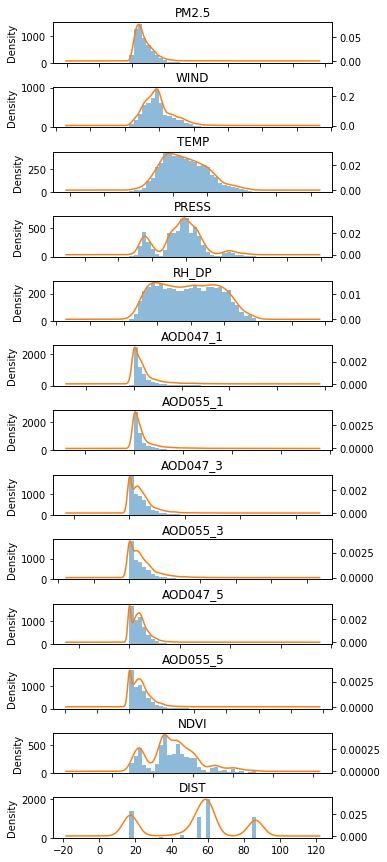

In [19]:
dftmp=df25
fig = plt.figure(figsize = (5,15))
ax0 = fig.add_subplot(len(columns),1,1)
dftmp['Arithmetic Mean'].hist(bins=30, alpha = 0.5,ax = ax0)
dftmp['Arithmetic Mean'].plot(kind = 'kde', secondary_y=True,ax = ax0)
ax0.title.set_text('PM2.5')
ax1 = fig.add_subplot(len(columns),1,2)
dftmp['WIND'].hist(bins=30, alpha = 0.5,ax = ax1)
dftmp['WIND'].plot(kind = 'kde', secondary_y=True,ax = ax1)
ax1.title.set_text('WIND')
ax2 = fig.add_subplot(len(columns),1,3)
dftmp['TEMP'].hist(bins=30, alpha = 0.5,ax = ax2)
dftmp['TEMP'].plot(kind = 'kde', secondary_y=True,ax = ax2)
ax2.title.set_text('TEMP')
ax3 = fig.add_subplot(len(columns),1,4)
dftmp['PRESS'].hist(bins=30, alpha = 0.5,ax = ax3)
dftmp['PRESS'].plot(kind = 'kde', secondary_y=True,ax = ax3)
ax3.title.set_text('PRESS')
ax4 = fig.add_subplot(len(columns),1,5)
dftmp['RH_DP'].hist(bins=30, alpha = 0.5,ax = ax4)
dftmp['RH_DP'].plot(kind = 'kde', secondary_y=True,ax = ax4)
ax4.title.set_text('RH_DP')
ax5 = fig.add_subplot(len(columns),1,6)
dftmp['AOD047_1'].hist(bins=30, alpha = 0.5,ax = ax5)
dftmp['AOD047_1'].plot(kind = 'kde', secondary_y=True,ax = ax5)
ax5.title.set_text('AOD047_1')
ax6 = fig.add_subplot(len(columns),1,7)
dftmp['AOD055_1'].hist(bins=30, alpha = 0.5,ax = ax6)
dftmp['AOD055_1'].plot(kind = 'kde', secondary_y=True,ax = ax6)
ax6.title.set_text('AOD055_1')
ax7 = fig.add_subplot(len(columns),1,8)
dftmp['AOD047_3'].hist(bins=30, alpha = 0.5,ax = ax7)
dftmp['AOD047_3'].plot(kind = 'kde', secondary_y=True,ax = ax7)
ax7.title.set_text('AOD047_3')
ax8 = fig.add_subplot(len(columns),1,9)
dftmp['AOD055_3'].hist(bins=30, alpha = 0.5,ax = ax8)
dftmp['AOD055_3'].plot(kind = 'kde', secondary_y=True,ax = ax8)
ax8.title.set_text('AOD055_3')
ax9 = fig.add_subplot(len(columns),1,10)
dftmp['AOD047_5'].hist(bins=30, alpha = 0.5,ax = ax9)
dftmp['AOD047_5'].plot(kind = 'kde', secondary_y=True,ax = ax9)
ax9.title.set_text('AOD047_5')
ax10 = fig.add_subplot(len(columns),1,11)
dftmp['AOD055_5'].hist(bins=30, alpha = 0.5,ax = ax10)
dftmp['AOD055_5'].plot(kind = 'kde', secondary_y=True,ax = ax10)
ax10.title.set_text('AOD055_5')
ax11 = fig.add_subplot(len(columns),1,12)
dftmp['NDVI'].hist(bins=30, alpha = 0.5,ax = ax11)
dftmp['NDVI'].plot(kind = 'kde', secondary_y=True,ax = ax11)
ax11.title.set_text('NDVI')
ax12 = fig.add_subplot(len(columns),1,13)
dftmp['dist'].hist(bins=30, alpha = 0.5,ax = ax12)
dftmp['dist'].plot(kind = 'kde', secondary_y=True,ax = ax12)
ax12.title.set_text('DIST')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.6)


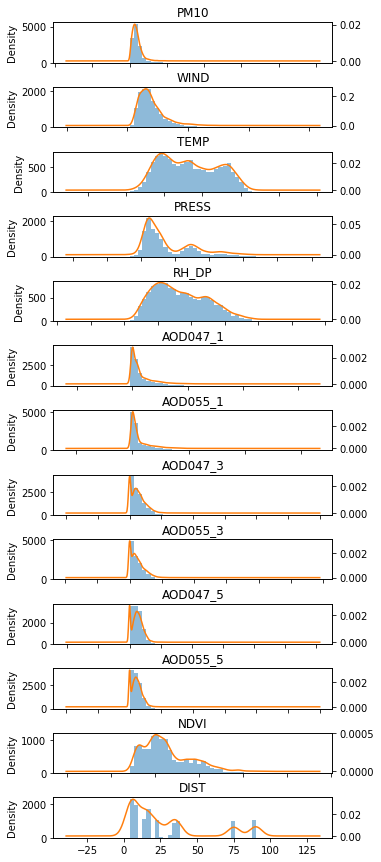

In [21]:
dftmp=df10
from pylab import *
fig = plt.figure(figsize = (5,15))
ax0 = fig.add_subplot(len(columns),1,1)
dftmp['Arithmetic Mean'].hist(bins=30, alpha = 0.5,ax = ax0)
dftmp['Arithmetic Mean'].plot(kind = 'kde', secondary_y=True,ax = ax0)
ax0.title.set_text('PM10')
ax1 = fig.add_subplot(len(columns),1,2)
dftmp['WIND'].hist(bins=30, alpha = 0.5,ax = ax1)
dftmp['WIND'].plot(kind = 'kde', secondary_y=True,ax = ax1)
ax1.title.set_text('WIND')
ax2 = fig.add_subplot(len(columns),1,3)
dftmp['TEMP'].hist(bins=30, alpha = 0.5,ax = ax2)
dftmp['TEMP'].plot(kind = 'kde', secondary_y=True,ax = ax2)
ax2.title.set_text('TEMP')
ax3 = fig.add_subplot(len(columns),1,4)
dftmp['PRESS'].hist(bins=30, alpha = 0.5,ax = ax3)
dftmp['PRESS'].plot(kind = 'kde', secondary_y=True,ax = ax3)
ax3.title.set_text('PRESS')
ax4 = fig.add_subplot(len(columns),1,5)
dftmp['RH_DP'].hist(bins=30, alpha = 0.5,ax = ax4)
dftmp['RH_DP'].plot(kind = 'kde', secondary_y=True,ax = ax4)
ax4.title.set_text('RH_DP')
ax5 = fig.add_subplot(len(columns),1,6)
dftmp['AOD047_1'].hist(bins=30, alpha = 0.5,ax = ax5)
dftmp['AOD047_1'].plot(kind = 'kde', secondary_y=True,ax = ax5)
ax5.title.set_text('AOD047_1')
ax6 = fig.add_subplot(len(columns),1,7)
dftmp['AOD055_1'].hist(bins=30, alpha = 0.5,ax = ax6)
dftmp['AOD055_1'].plot(kind = 'kde', secondary_y=True,ax = ax6)
ax6.title.set_text('AOD055_1')
ax7 = fig.add_subplot(len(columns),1,8)
dftmp['AOD047_3'].hist(bins=30, alpha = 0.5,ax = ax7)
dftmp['AOD047_3'].plot(kind = 'kde', secondary_y=True,ax = ax7)
ax7.title.set_text('AOD047_3')
ax8 = fig.add_subplot(len(columns),1,9)
dftmp['AOD055_3'].hist(bins=30, alpha = 0.5,ax = ax8)
dftmp['AOD055_3'].plot(kind = 'kde', secondary_y=True,ax = ax8)
ax8.title.set_text('AOD055_3')
ax9 = fig.add_subplot(len(columns),1,10)
dftmp['AOD047_5'].hist(bins=30, alpha = 0.5,ax = ax9)
dftmp['AOD047_5'].plot(kind = 'kde', secondary_y=True,ax = ax9)
ax9.title.set_text('AOD047_5')
ax10 = fig.add_subplot(len(columns),1,11)
dftmp['AOD055_5'].hist(bins=30, alpha = 0.5,ax = ax10)
dftmp['AOD055_5'].plot(kind = 'kde', secondary_y=True,ax = ax10)
ax10.title.set_text('AOD055_5')
ax11 = fig.add_subplot(len(columns),1,12)
dftmp['NDVI'].hist(bins=30, alpha = 0.5,ax = ax11)
dftmp['NDVI'].plot(kind = 'kde', secondary_y=True,ax = ax11)
ax11.title.set_text('NDVI')
ax12 = fig.add_subplot(len(columns),1,13)
dftmp['dist'].hist(bins=30, alpha = 0.5,ax = ax12)
dftmp['dist'].plot(kind = 'kde', secondary_y=True,ax = ax12)
ax12.title.set_text('DIST')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.6)


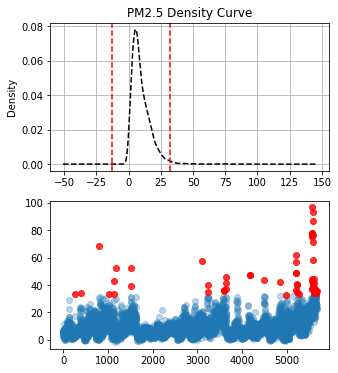

In [24]:
#stats.kstest(data,'norm', (u, std))
data=df25['Arithmetic Mean'].reset_index(drop=True)
u, std = np.mean(data), np.std(data)
fig= plt.figure(figsize=(5,6))
ax1=fig.add_subplot(2,1,1)
data.plot(kind='kde',style='--k',grid=True,title='PM2.5 Density Curve')
plt.axvline(u+3*std,linestyle='--',color='r')
plt.axvline(u-3*std,linestyle='--',color='r')
error = data[np.abs(data - u) > 3*std]
data_c = data[np.abs(data - u) <= 3*std]
ax2=fig.add_subplot(2,1,2)
plt.scatter(data_c.index,data_c,alpha=0.3)
plt.scatter(error.index,error,color='r',marker='o',alpha=0.8)

C:\Users\xurui\Anaconda3\envs\gpu38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


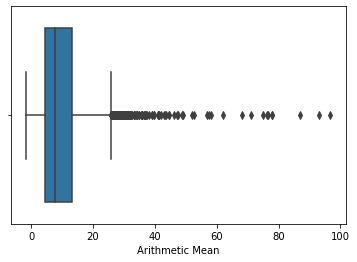

In [ ]:
sns.boxplot(data)

In [26]:
df10[['Arithmetic Mean','WIND', 'TEMP', 'PRESS', 'RH_DP', 'AOD047_1','AOD055_1', 'AOD047_3', 'AOD055_3', 'AOD047_5', 'AOD055_5','NDVI','dist']].corr()

,Arithmetic Mean,WIND,TEMP,PRESS,RH_DP,AOD047_1,AOD055_1,AOD047_3,AOD055_3,AOD047_5,AOD055_5,NDVI,dist
Arithmetic Mean,1.000000,0.232958,0.283948,-0.063946,-0.106590,0.081004,0.077631,0.114137,0.105689,0.126854,0.116544,0.027668,-0.028389
WIND,0.232958,1.000000,0.204076,-0.161093,-0.054823,0.087382,0.090398,0.141166,0.143107,0.153971,0.156636,-0.110005,-0.262558
TEMP,0.283948,0.204076,1.000000,-0.096807,-0.355586,0.141986,0.134174,0.231442,0.216304,0.289933,0.274177,-0.130750,-0.198897
PRESS,-0.063946,-0.161093,-0.096807,1.000000,-0.214120,-0.041082,-0.045287,-0.050844,-0.057899,-0.034464,-0.042909,0.068247,0.277010
RH_DP,-0.106590,-0.054823,-0.355586,-0.214120,1.000000,-0.068502,-0.060585,-0.097538,-0.083135,-0.162615,-0.148568,-0.015335,0.283381
AOD047_1,0.081004,0.087382,0.141986,-0.041082,-0.068502,1.000000,0.994468,0.704790,0.705425,0.594580,0.598627,-0.039242,-0.150187
AOD055_1,0.077631,0.090398,0.134174,-0.045287,-0.060585,0.994468,1.000000,0.687654,0.695971,0.573307,0.584043,-0.039367,-0.158691
AOD047_3,0.114137,0.141166,0.231442,-0.050844,-0.097538,0.704790,0.687654,1.000000,0.995102,0.898935,0.898911,-0.076046,-0.171351
AOD055_3,0.105689,0.143107,0.216304,-0.057899,-0.083135,0.705425,0.695971,0.995102,1.000000,0.882221,0.892199,-0.078583,-0.176604
AOD047_5,0.126854,0.153971,0.289933,-0.034464,-0.162615,0.594580,0.573307,0.898935,0.882221,1.000000,0.994116,-0.072957,-0.214625


Text(0.5, 1.0, 'PM2.5 Heatmap')

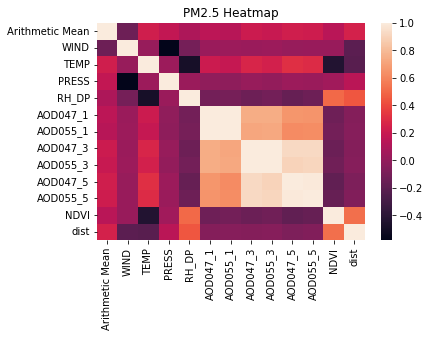

In [ ]:
sns.heatmap(df25[['Arithmetic Mean','WIND', 'TEMP', 'PRESS', 'RH_DP', 'AOD047_1','AOD055_1', 'AOD047_3', 'AOD055_3', 'AOD047_5', 'AOD055_5','NDVI','dist']].corr())
plt.title('PM2.5 Heatmap')

Text(0.5, 1.0, 'PM10 Heatmap')

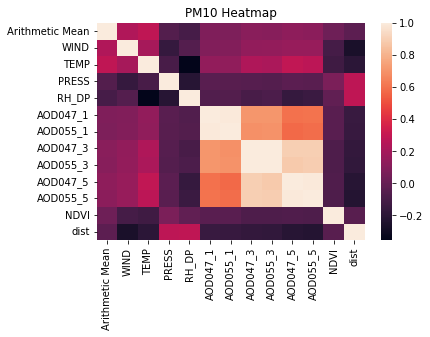

In [ ]:
sns.heatmap(df10[['Arithmetic Mean','WIND', 'TEMP', 'PRESS', 'RH_DP', 'AOD047_1','AOD055_1', 'AOD047_3', 'AOD055_3', 'AOD047_5', 'AOD055_5','NDVI','dist']].corr())
plt.title('PM10 Heatmap')

(array([3.270e+02, 4.376e+03, 5.951e+03, 1.293e+03, 2.100e+02, 6.200e+01,
        2.200e+01, 1.100e+01, 1.000e+00, 1.000e+00]),
 array([ 0.        ,  2.60768096,  5.21536192,  7.82304289, 10.43072385,
        13.03840481, 15.64608577, 18.25376673, 20.8614477 , 23.46912866,
        26.07680962]),
 <BarContainer object of 10 artists>)

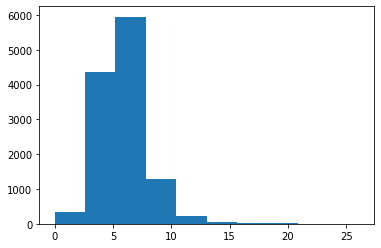

In [ ]:
plt.hist([(i)**.5 for i in df10['Arithmetic Mean']])

In [ ]:
df10[['Arithmetic Mean','WIND', 'TEMP', 'PRESS', 'RH_DP', 'AOD047_1','AOD055_1', 'AOD047_3', 'AOD055_3', 'AOD047_5', 'AOD055_5','NDVI', 'dist','year']].corr()

,Arithmetic Mean,WIND,TEMP,PRESS,RH_DP,AOD047_1,AOD055_1,AOD047_3,AOD055_3,AOD047_5,AOD055_5,NDVI,dist,year
Arithmetic Mean,1.000000,0.232958,0.283948,-0.063946,-0.106590,0.075841,0.076557,0.114137,0.105689,0.126854,0.116544,0.027623,-0.028389,-0.047476
WIND,0.232958,1.000000,0.204076,-0.161093,-0.054823,0.067386,0.068822,0.141166,0.143107,0.153971,0.156636,-0.109813,-0.262558,-0.026322
TEMP,0.283948,0.204076,1.000000,-0.096807,-0.355586,0.238467,0.239315,0.231442,0.216304,0.289933,0.274177,-0.130897,-0.198897,-0.017527
PRESS,-0.063946,-0.161093,-0.096807,1.000000,-0.214120,0.027370,0.027347,-0.050844,-0.057899,-0.034464,-0.042909,0.068128,0.277010,0.283175
RH_DP,-0.106590,-0.054823,-0.355586,-0.214120,1.000000,-0.256004,-0.256490,-0.097538,-0.083135,-0.162615,-0.148568,-0.014790,0.283381,-0.075047
AOD047_1,0.075841,0.067386,0.238467,0.027370,-0.256004,1.000000,0.999913,0.580495,0.549404,0.633837,0.606380,-0.046782,-0.069752,0.055356
AOD055_1,0.076557,0.068822,0.239315,0.027347,-0.256490,0.999913,1.000000,0.581143,0.550371,0.634459,0.607208,-0.046608,-0.072620,0.056059
AOD047_3,0.114137,0.141166,0.231442,-0.050844,-0.097538,0.580495,0.581143,1.000000,0.995102,0.898935,0.898911,-0.075607,-0.171351,0.015969
AOD055_3,0.105689,0.143107,0.216304,-0.057899,-0.083135,0.549404,0.550371,0.995102,1.000000,0.882221,0.892199,-0.078352,-0.176604,0.012001
AOD047_5,0.126854,0.153971,0.289933,-0.034464,-0.162615,0.633837,0.634459,0.898935,0.882221,1.000000,0.994116,-0.072606,-0.214625,0.033721


Text(0.5, 1.0, 'PM10 Heatmap')

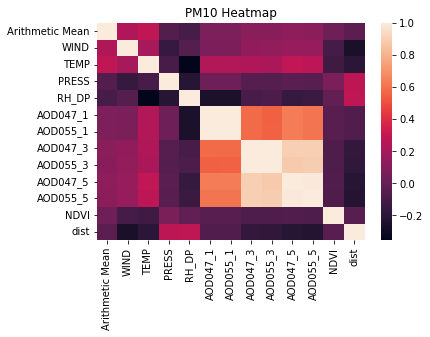

In [ ]:
sns.heatmap(df10[['Arithmetic Mean','WIND', 'TEMP', 'PRESS', 'RH_DP', 'AOD047_1','AOD055_1', 'AOD047_3', 'AOD055_3', 'AOD047_5', 'AOD055_5','NDVI', 'dist']].corr())
plt.title('PM10 Heatmap')

C:\Users\xurui\Anaconda3\envs\gpu38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='dist', ylabel='Arithmetic Mean'>

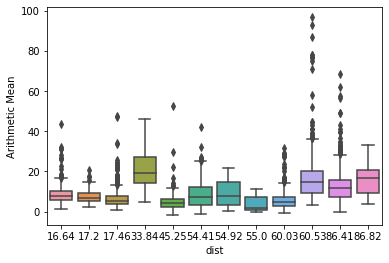

In [ ]:
sns.boxplot(df25['dist'], df25['Arithmetic Mean'])

# model

In [62]:
df25 = pd.read_csv('d:\msda\pm2.5.csv')
df10 = pd.read_csv('d:\msda\pm10.csv')
df25['year'] = df25['year'].apply(float)
df10['year'] = df10['year'].apply(float)
df25['month'] = df25['month'].apply(str)
df10['month'] = df10['month'].apply(str)
df25['LU'] = df25['LU'].apply(str)
df10['LU'] = df10['LU'].apply(str)
df25['NDVI'] = df25['NDVI'].apply(float)
df10['NDVI'] = df10['NDVI'].apply(float)
#df25.drop(columns = ['Date Local'], inplace = True)
#df10.drop(columns = ['Date Local'], inplace = True)

'''df10 = df10.dropna().reset_index(drop = True)
df25 = df25.dropna()
'''
len(df10), len(df25)

(12254, 5664)

In [28]:
df25.isna().sum()

Arithmetic Mean    0
month              0
AOD047_1           0
year               0
AOD055_1           0
AOD047_3           0
AOD055_3           0
AOD047_5           0
AOD055_5           0
LU                 0
NDVI               0
WIND               0
TEMP               0
PRESS              0
RH_DP              0
dist               0
dtype: int64

In [29]:
df10.isna().sum()

Arithmetic Mean    0
year               0
month              0
AOD047_1           0
AOD055_1           0
AOD047_3           0
AOD055_3           0
AOD047_5           0
AOD055_5           0
LU                 0
NDVI               0
WIND               0
TEMP               0
PRESS              0
RH_DP              0
dist               0
dtype: int64

## modeling-pm2.5

### data pre-processing

In [55]:
df25.columns

Index(['Arithmetic Mean', 'month', 'AOD047_1', 'year', 'AOD055_1', 'AOD047_3',
       'AOD055_3', 'AOD047_5', 'AOD055_5', 'LU', 'NDVI', 'WIND', 'TEMP',
       'PRESS', 'RH_DP', 'dist'],
      dtype='object')

In [63]:
dftmp = df25[['Arithmetic Mean','month', 'AOD047_1','year',
       'AOD055_1', 'AOD047_3', 'AOD055_3', 'AOD047_5', 'AOD055_5', 'LU',
       'NDVI', 'WIND', 'TEMP', 'PRESS', 'RH_DP', 'dist']]
dftmp.loc[(dftmp['AOD047_1']<-100), 'AOD047_1']=0 # for the valid range for aod is (-100, 5000)
dftmp.loc[(dftmp['AOD055_1']<-100), 'AOD055_1']=0 

In [64]:
dftmp.describe()

,Arithmetic Mean,AOD047_1,year,AOD055_1,AOD047_3,AOD055_3,AOD047_5,AOD055_5,NDVI,WIND,TEMP,PRESS,RH_DP,dist
count,5664.000000,5664.000000,5664.000000,5664.000000,5664.000000,5664.000000,5664.000000,5664.000000,5664.000000,5664.000000,5664.000000,5664.000000,5664.000000,5664.000000
mean,9.656268,191.410311,2019.069386,166.310734,192.044531,167.319562,190.011963,165.543305,2995.035664,4.822475,66.730763,970.935081,48.120277,52.953148
std,7.598124,288.104712,0.802580,271.293232,204.123315,186.282584,175.897348,156.856799,1248.583526,2.121721,12.738781,16.257265,22.068329,23.387489
min,-1.700000,-96.000000,2018.000000,-98.000000,0.000000,0.000000,0.000000,0.000000,844.000000,0.660000,34.720000,933.110000,4.400000,16.640000
25%,4.600000,0.000000,2018.000000,0.000000,0.000000,0.000000,50.990000,39.710000,2333.000000,3.380000,56.915000,963.240000,28.830000,33.840000
50%,7.700000,106.000000,2019.000000,79.000000,151.666667,122.333333,170.880000,141.760000,2930.000000,4.550000,65.500000,972.545000,48.020000,60.030000
75%,13.100000,233.000000,2020.000000,190.000000,275.694444,240.583333,275.220000,240.980000,3663.000000,5.780000,75.722500,980.572500,66.422500,60.530000
max,96.700000,2563.000000,2020.000000,2499.000000,2286.333333,1787.555556,2516.040000,1961.640000,7169.000000,19.090000,108.320000,1027.260000,98.740000,86.820000


In [65]:
from scipy import stats
data = dftmp['Arithmetic Mean']
m, std = np.mean(data), stats.tstd(data)
print(m,std,[m-3*std, m+3*std])
dftmp = pd.get_dummies(data=dftmp, drop_first=True)
low, up = np.quantile(data, (0.01, 0.99))
print(low, up)
dftmp = dftmp.drop(dftmp[dftmp['Arithmetic Mean']> up].index)
dftmp = dftmp.drop(dftmp[dftmp['Arithmetic Mean']< low].index)
dftmp = dftmp.drop(dftmp[dftmp['Arithmetic Mean']<0].index)
dftmp.describe()

9.656267655367216 7.598124222477567 [-13.138105012065488, 32.45064032279992]
0.3 33.410999999999966


,Arithmetic Mean,AOD047_1,year,AOD055_1,AOD047_3,AOD055_3,AOD047_5,AOD055_5,NDVI,WIND,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,LU_30,LU_40,LU_9
count,5555.000000,5555.000000,5555.000000,5555.000000,5555.000000,5555.000000,5555.000000,5555.000000,5555.000000,5555.000000,...,5555.000000,5555.000000,5555.000000,5555.000000,5555.000000,5555.000000,5555.000000,5555.000000,5555.000000,5555.000000
mean,9.353609,189.981818,2019.064986,165.221782,190.713691,166.360256,188.554599,164.469401,2990.450225,4.813091,...,0.079928,0.085149,0.096310,0.090009,0.083888,0.090009,0.079568,0.328893,0.131413,0.355896
std,6.315499,285.453564,0.800785,269.688358,200.679325,184.410183,171.394365,154.164166,1255.506077,2.099737,...,0.271206,0.279128,0.295042,0.286220,0.277245,0.286220,0.270648,0.469853,0.337882,0.478827
min,0.300000,-96.000000,2018.000000,-98.000000,0.000000,0.000000,0.000000,0.000000,844.000000,0.660000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.600000,0.000000,2018.000000,0.000000,0.000000,0.000000,51.440000,39.980000,2322.000000,3.375000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.700000,106.000000,2019.000000,79.000000,151.666667,122.333333,170.960000,141.760000,2927.000000,4.550000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,12.900000,232.000000,2020.000000,188.000000,274.222222,238.666667,273.580000,239.520000,3657.000000,5.770000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,33.300000,2563.000000,2020.000000,2499.000000,2286.333333,1787.555556,2516.040000,1961.640000,7169.000000,19.090000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [88]:
X = dftmp.drop(columns=['Arithmetic Mean'])
y = dftmp['Arithmetic Mean']

X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=1, test_size=0.4)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test,random_state=1, test_size=0.5)
print(X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape)
sc_X = StandardScaler()
X_trainscaled=sc_X.fit_transform(X_train)
X_testscaled=sc_X.transform(X_test)
X_valscaled=sc_X.transform(X_val)
X_trainscaled.shape

(3333, 27) (1111, 27) (1111, 27) (3333,) (1111,) (1111,)


(3333, 27)

In [89]:
X_ = sc_X.transform(X)

In [67]:
# pickle.dump(sc_X, open(r'd:\msda\data298\new\scaler_pm2.5.pkl','wb'))
# sc_X = pickle.load(open('d:\msda\data298\new\scaler_pm2.5.pkl', 'rb'))

### LR

As baseline

In [43]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_trainscaled, y_train)

In [44]:
y_pred1=reg.predict(X_valscaled)
score_model(y_val, y_pred1)
y_pred2=reg.predict(X_testscaled)
score_model(y_test, y_pred2)

R2 score:  0.43, RMSE: 4.78, MAE:  3.55
R2 score:  0.43, RMSE: 4.71, MAE:  3.53


(4.71250747379439, 3.5270406000436876)

### RFR - pm2.5

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
n_estimators.append(50)
n_estimators.append(100)
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2]#, 5, 10, 15, 20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2]#, 4, 6, 8, 10]
# Method of selecting samples for training each tree
bootstrap = [True]#, False]
# Create the random grid
grid_para = {'n_estimators': n_estimators,
        'max_features': max_features,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Grid search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_GridSearch=GridSearchCV(rf,param_grid=grid_para, cv=3, return_train_score=True, verbose=2, scoring = 'neg_mean_absolute_error', n_jobs=-1)
#rf_random = RandomizedSearchCV(estimator = rf, param_distributions = grid_para, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_GridSearch.fit(X_trainscaled, y_train)
y_pred1=rf_GridSearch.predict(X_valscaled)
score_model(y_val, y_pred1)
y_pred2=rf_GridSearch.predict(X_testscaled)
score_model(y_test, y_pred2)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
R2 score:  0.59, RMSE: 4.04, MAE:  2.83
R2 score:  0.59, RMSE: 3.97, MAE:  2.85


(3.969174349316154, 2.8452099184055513)

{'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 2000}
R2 score:  0.59, RMSE: 4.04, MAE:  2.83
R2 score:  0.59, RMSE: 3.97, MAE:  2.85


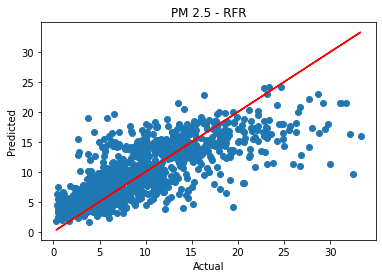

In [ ]:
print(rf_GridSearch.best_params_)
y_pred1=rf_GridSearch.predict(X_valscaled)
score_model(y_val, y_pred1)
y_pred2=rf_GridSearch.predict(X_testscaled)
score_model(y_test, y_pred2)
plt.scatter(y_test, y_pred2)
plt.title('PM 2.5 - RFR')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.plot(y_test, y_test, color = 'red')

In [ ]:
joblib.dump(rf_GridSearch, r"d:\msda\data298\model\rfr_best_pm2.5.joblib")

['d:\\msda\\data298\\model\\rfr_best_pm2.5_1018.joblib']

R2 score:  0.50, RMSE: 4.42, MAE:  3.25
R2 score:  0.50, RMSE: 4.47, MAE:  3.37


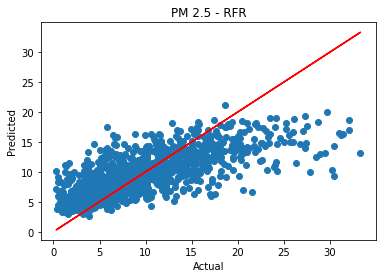

In [ ]:
forest=RandomForestRegressor(n_estimators= 1000,  min_samples_split= 2, 
            min_samples_leaf= 2,  max_features= 'sqrt', max_depth=20, 
            bootstrap=True, criterion='mse', random_state=1, n_jobs=1)

forest.fit(X_trainscaled,y_train)
y_pred1=forest.predict(X_testscaled)
score_model(y_test, y_pred1)
y_pred2=forest.predict(X_valscaled)
score_model(y_val, y_pred2)




plt.scatter(y_val, y_pred2)
plt.title('PM 2.5 - RFR')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.plot(y_test, y_test, color = 'red')

### SVR

In [ ]:
from sklearn.svm import SVR
# pm2.5
C = [0.1, 1, 100, 1000]
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
gamma =['scale', 'auto']
grid_para = {'kernel': kernel, 'C': C, 'gamma':gamma}
svr = SVR()
# Grid search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
svr_GridSearch=GridSearchCV(svr, param_grid=grid_para, cv=3, return_train_score=True, verbose=2, scoring = 'neg_mean_absolute_error', n_jobs=-1)
svr_GridSearch.fit(X_trainscaled, y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


GridSearchCV(cv=3, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 100, 1000], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=2)

{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
R2 score:  0.58, RMSE: 4.11, MAE:  2.85
R2 score:  0.56, RMSE: 4.12, MAE:  2.82


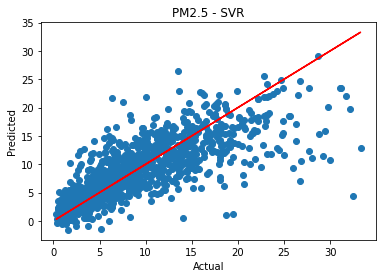

In [ ]:
print(svr_GridSearch.best_params_)

y_pred1 = svr_GridSearch.predict(X_valscaled)
score_model(y_val, y_pred1)
y_pred2 = svr_GridSearch.predict(X_testscaled)
score_model(y_test, y_pred2)
plt.scatter(y_test, y_pred2)
plt.title('PM2.5 - SVR')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.plot(y_test, y_test, color = 'red')


{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
R2 score:  0.56, RMSE: 4.21, MAE:  2.94
R2 score:  0.53, RMSE: 4.29, MAE:  2.93


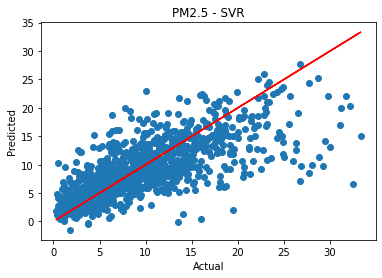

In [ ]:
print(svr_GridSearch.best_params_)
# with year avg weather
y_pred1 = svr_GridSearch.predict(X_valscaled)
score_model(y_val, y_pred1)
y_pred2 = svr_GridSearch.predict(X_testscaled)
score_model(y_test, y_pred2)
plt.scatter(y_test, y_pred2)
plt.title('PM2.5 - SVR')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.plot(y_test, y_test, color = 'red')


{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
R2 score:  0.45, RMSE: 4.70, MAE:  3.35
R2 score:  0.46, RMSE: 4.57, MAE:  3.24


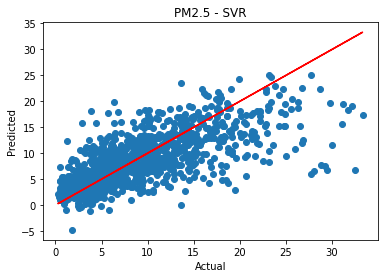

In [ ]:
print(svr_GridSearch.best_params_)

y_pred1 = svr_GridSearch.predict(X_valscaled)
score_model(y_val, y_pred1)
y_pred2 = svr_GridSearch.predict(X_testscaled)
score_model(y_test, y_pred2)
plt.scatter(y_test, y_pred2)
plt.title('PM2.5 - SVR')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.plot(y_test, y_test, color = 'red')


In [ ]:
joblib.dump(svr_GridSearch, r"d:\msda\data298\model\svr_best_pm2.5.joblib")

['d:\\msda\\data298\\model\\svr_best_pm2.5_1018.joblib']

### MLP - pm2.5

In [ ]:
seed=42
drop_rate=0.3
init = tf.keras.initializers.GlorotUniform(seed=seed)
def build_reg(unit1,unit2,unit3,unit4,unit5,unit6,unit7):
    ann = tf.keras.models.Sequential()
    ann.add(tf.keras.layers.Dense(input_dim=X_trainscaled.shape[1],units=unit1,kernel_initializer=init, activation='relu'))
    ann.add(Dropout(drop_rate))
    ann.add(tf.keras.layers.Dense(units=unit2,kernel_initializer=init, activation='relu'))
    ann.add(Dropout(drop_rate))
    ann.add(tf.keras.layers.Dense(units=unit3,kernel_initializer=init, activation='relu'))
    ann.add(Dropout(drop_rate))
    ann.add(tf.keras.layers.Dense(units=unit4,kernel_initializer=init, activation='relu'))
    ann.add(Dropout(drop_rate))
    ann.add(tf.keras.layers.Dense(units=unit5,kernel_initializer=init, activation='relu'))
    ann.add(Dropout(drop_rate))
    ann.add(tf.keras.layers.Dense(units=unit6,kernel_initializer=init, activation='relu'))
    ann.add(Dropout(drop_rate))
    ann.add(tf.keras.layers.Dense(units=unit7,kernel_initializer=init, activation='relu'))
    ann.add(tf.keras.layers.Dense(units=1, activation='relu'))
    ann.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mae','mse'])
    print(unit1,unit2,unit3,unit4,unit5,unit6,unit7)
    return ann

model=KerasRegressor(build_fn=build_reg)
params={'batch_size':[16,32,64,128,256,512],
        'nb_epoch':[100],
        'unit1':[1000,1500,2000,3000,4000,5000],
        'unit2':[1000,1500,2000,3000,4000,5000],
        'unit3':[1000,1500,2000,3000,4000,5000],
        'unit4':[1000,1500,2000,3000,4000,5000],
        }
gs=GridSearchCV(estimator=model, param_grid=params, cv=10)
gs = gs.fit(X_trainscaled, y_train,validation_data=(X_valscaled, y_val))

In [75]:
activation='relu'
init=tf.keras.initializers.GlorotUniform()
drop_rate=[0.2,0.3,0.5]
n5=1
EPOCHS=100
model = Sequential()
model.add(Dense(5000, input_dim=X_trainscaled.shape[1], kernel_initializer=init, activation=activation))
model.add(Dropout(0.3))
model.add(Dense(1500, kernel_initializer=init, activation=activation))
model.add(Dropout(0.3))
model.add(Dense(5000, kernel_initializer=init, activation=activation))
model.add(Dropout(0.3))
model.add(Dense(1000, kernel_initializer=init, activation=activation))
model.add(Dense(1))
# Compile model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
#model.summary()
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_trainscaled, y_train, validation_data=(X_valscaled, y_val),batch_size=512, 
                    epochs=EPOCHS, verbose=0, callbacks=[early_stop])
y_pred1 = model.predict(X_valscaled)
rmse, mae = score_model(y_val, y_pred1)
y_pred2 = model.predict(X_testscaled)
score_model(y_test, y_pred2)

R2 score:  0.60, RMSE: 3.99, MAE:  2.71
R2 score:  0.60, RMSE: 3.94, MAE:  2.75


(3.943020970268547, 2.7539504141554327)

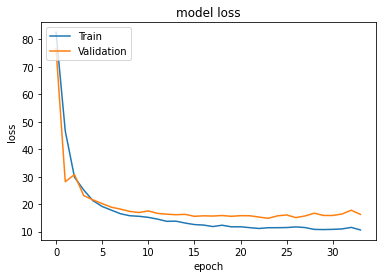

R2 score:  0.59, RMSE: 4.04, MAE:  2.82
R2 score:  0.60, RMSE: 3.95, MAE:  2.78


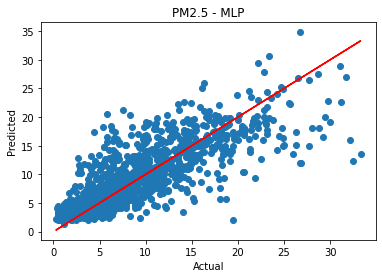

In [69]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
y_pred1 = model.predict(X_valscaled)
score_model(y_val, y_pred1)
y_pred2 = model.predict(X_testscaled)
score_model(y_test, y_pred2)
plt.scatter(y_test, y_pred2)
plt.title('PM2.5 - MLP')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.plot(y_test, y_test, color = 'red')

In [ ]:
model.save(r"d:\msda\data298\model\mlp_best_pm2.5.h5")

R2 score:  0.77, RMSE: 3.06, MAE:  2.17
R2 score:  0.60, RMSE: 3.99, MAE:  2.71
R2 score:  0.60, RMSE: 3.94, MAE:  2.75


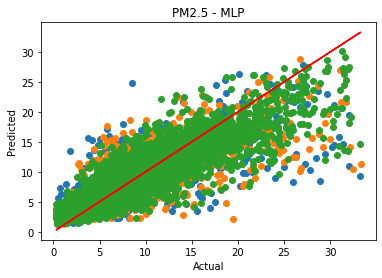

In [80]:
y_pred3 = model.predict(X_trainscaled)
score_model(y_train, y_pred3)
y_pred1 = model.predict(X_valscaled)
score_model(y_val, y_pred1)
y_pred2 = model.predict(X_testscaled)
score_model(y_test, y_pred2)

plt.scatter(y_val, y_pred1)
plt.scatter(y_test, y_pred2)
plt.scatter(y_train, y_pred3)
plt.title('PM2.5 - MLP')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.plot(y_test, y_test, color = 'red')

In [78]:
model_saved = tf. keras. models. load_model(r"d:\msda\data298\model\mlp_best_pm2.5.h5")

R2 score:  0.62, RMSE: 3.89, MAE:  2.64
R2 score:  0.62, RMSE: 3.86, MAE:  2.66


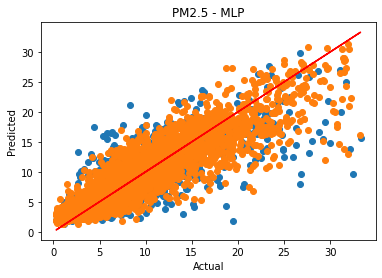

In [98]:
y_pred3 = model_saved.predict(X_trainscaled)
#score_model(y_train, y_pred3)
y_pred1 = model_saved.predict(X_valscaled)
score_model(y_val, y_pred1)
y_pred2 = model_saved.predict(X_testscaled)
score_model(y_test, y_pred2)

#plt.scatter(y_val, y_pred1)
plt.scatter(y_test, y_pred2)
plt.scatter(y_train, y_pred3)
plt.title('PM2.5 - MLP')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.plot(y_test, y_test, color = 'red')

#### sklearn

In [ ]:
grid_para = {'hidden_layer_sizes': [[2000,2000,2000,2000],[2000,2000,2000,2000,2000],[2000,1000,1000,1000],[3000,2000,1000]],#[[2000, 2000],[1000,1000],[2000,2000,2000],[1000,2000,1000], [100,200,200,100]], 
             'activation': ['relu'], 
             'solver': ['adam','sgd']}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
reg = MLPRegressor()
mlp_GridSearch = GridSearchCV(estimator = reg, param_grid=grid_para, cv=3, return_train_score=True, verbose=2, scoring = 'neg_mean_absolute_error', n_jobs=-1)
with tf.device('/GPU:0'):
    mlp_GridSearch.fit(X_trainscaled, y_train)
mlp_GridSearch.best_params_

Fitting 3 folds for each of 8 candidates, totalling 24 fits


{'activation': 'relu', 'hidden_layer_sizes': [1000, 1000], 'solver': 'adam'}
R2 score:  0.56, RMSE: 4.19, MAE:  2.90
R2 score:  0.57, RMSE: 4.09, MAE:  2.76


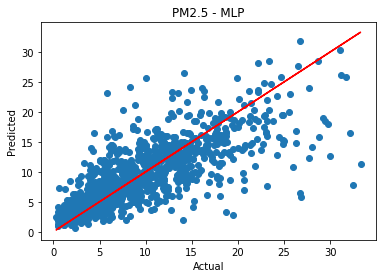

In [ ]:
print(mlp_GridSearch.best_params_)

y_pred1 = mlp_GridSearch.predict(X_valscaled)
score_model(y_val, y_pred1)
y_pred2 = mlp_GridSearch.predict(X_testscaled)
score_model(y_test, y_pred2)
plt.scatter(y_test, y_pred2)
plt.title('PM2.5 - MLP')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.plot(y_test, y_test, color = 'red')

In [ ]:
joblib.dump(mlp_GridSearch, r"d:\msda\data298\model\mlp_best_pm2.5_1022.joblib")

['d:\\msda\\data298\\model\\mlp_best_pm2.5_1018.joblib']

{'activation': 'relu', 'hidden_layer_sizes': [1000, 1000], 'solver': 'adam'}
R2 score:  0.56, RMSE: 4.19, MAE:  2.90
R2 score:  0.57, RMSE: 4.09, MAE:  2.76


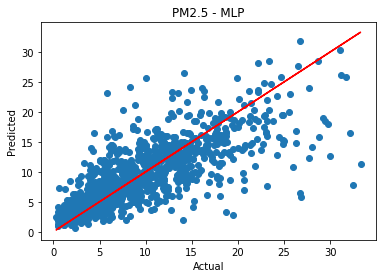

In [ ]:
print(mlp_GridSearch.best_params_)

y_pred1 = mlp_GridSearch.predict(X_valscaled)
score_model(y_val, y_pred1)
y_pred2 = mlp_GridSearch.predict(X_testscaled)
score_model(y_test, y_pred2)
plt.scatter(y_test, y_pred2)
plt.title('PM2.5 - MLP')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.plot(y_test, y_test, color = 'red')

## modeling-pm10

### pre-processing

In [45]:
df10

,Arithmetic Mean,year,month,AOD047_1,AOD055_1,AOD047_3,AOD055_3,AOD047_5,AOD055_5,LU,NDVI,WIND,TEMP,PRESS,RH_DP,dist
0,169,2018.0,1,539.0,509.0,600.444444,571.333333,376.92,355.04,9,1732.0,1.36,60.49,971.40,30.89,32.70
1,70,2018.0,1,152.0,117.0,401.000000,372.555556,373.84,348.68,9,1732.0,1.28,65.95,971.07,21.84,32.70
2,106,2018.0,1,0.0,0.0,0.000000,0.000000,0.00,0.00,9,1732.0,1.20,63.90,968.79,21.26,32.70
3,82,2018.0,1,134.0,99.0,104.111111,77.000000,116.20,94.56,9,1732.0,1.15,65.37,969.86,26.88,32.70
4,119,2018.0,1,46.0,34.0,41.444444,30.333333,67.00,56.08,9,1732.0,1.19,66.31,971.47,47.76,32.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12249,15,2020.0,12,0.0,0.0,0.000000,0.000000,0.00,0.00,9,2449.0,1.34,51.37,971.64,73.22,75.13
12250,2,2020.0,12,0.0,0.0,0.000000,0.000000,0.00,0.00,9,2449.0,2.04,46.20,969.71,85.62,75.13
12251,4,2020.0,12,450.0,0.0,457.777778,335.777778,387.92,333.44,9,2449.0,3.64,48.33,978.75,62.14,75.13
12252,9,2020.0,12,0.0,0.0,92.666667,85.555556,277.92,267.88,9,2449.0,1.65,51.68,984.80,35.49,75.13


In [46]:
df10.columns

Index(['Arithmetic Mean', 'year', 'month', 'AOD047_1', 'AOD055_1', 'AOD047_3',
       'AOD055_3', 'AOD047_5', 'AOD055_5', 'LU', 'NDVI', 'WIND', 'TEMP',
       'PRESS', 'RH_DP', 'dist'],
      dtype='object')

In [100]:
dftmp = df10[['Arithmetic Mean', 'year', 'month', 'AOD047_1',
       'AOD055_1', 'AOD047_3', 'AOD055_3', 'AOD047_5', 'AOD055_5', 'LU',
       'NDVI', 'WIND', 'TEMP', 'PRESS', 'RH_DP','dist']]
dftmp.loc[(dftmp['AOD047_1']<-100), 'AOD047_1']=0 # for the valid range for aod is (-100, 5000)
dftmp.loc[(dftmp['AOD055_1']<-100), 'AOD055_1']=0 

In [101]:
dftmp.describe()

,Arithmetic Mean,year,AOD047_1,AOD055_1,AOD047_3,AOD055_3,AOD047_5,AOD055_5,NDVI,WIND,TEMP,PRESS,RH_DP,dist
count,12254.000000,12254.000000,12254.000000,12254.000000,12254.000000,12254.000000,12254.000000,12254.000000,12254.000000,12254.000000,12254.000000,12254.000000,12254.000000,12254.000000
mean,38.842092,2019.030684,270.453974,239.453403,252.501750,223.687775,240.577415,212.918077,2497.587237,3.896564,73.053730,974.588162,41.835872,27.455441
std,30.731058,0.813984,389.949199,374.067465,229.882626,214.846873,184.362848,169.285821,1067.129346,2.147375,14.726945,13.896505,19.386685,27.191753
min,0.000000,2018.000000,-100.000000,-98.000000,0.000000,0.000000,0.000000,0.000000,844.000000,0.360000,41.750000,953.330000,4.080000,4.000000
25%,21.000000,2018.000000,0.000000,0.000000,64.472222,48.222222,108.880000,88.750000,1737.000000,2.432500,60.180000,964.562500,26.070000,7.070000
50%,33.000000,2019.000000,135.000000,97.000000,217.333333,180.388889,235.600000,201.880000,2263.000000,3.420000,71.775000,969.110000,38.790000,16.640000
75%,48.000000,2020.000000,360.000000,303.000000,378.083333,337.250000,353.670000,314.640000,3101.000000,4.780000,86.037500,984.407500,56.867500,36.800000
max,680.000000,2020.000000,4489.000000,4411.000000,4002.888889,3927.111111,4081.480000,4005.640000,6605.000000,21.270000,108.320000,1027.670000,98.690000,90.470000


In [102]:
from scipy import stats
data = dftmp['Arithmetic Mean']
m, std = np.mean(data), stats.tstd(data)
print(m,std,[m-3*std, m+3*std])
dftmp = pd.get_dummies(data=dftmp, drop_first=True)
low, up = np.quantile(data, (0.01, 0.99))
print(low, up)
dftmp = dftmp.drop(dftmp[dftmp['Arithmetic Mean']> up].index)
dftmp = dftmp.drop(dftmp[dftmp['Arithmetic Mean']< low].index)
dftmp = dftmp.drop(dftmp[dftmp['Arithmetic Mean']<0].index)
dftmp.describe()

38.84209237799902 30.731057553750794 [-53.35108028325337, 131.0352650392514]
5.0 152.0


,Arithmetic Mean,year,AOD047_1,AOD055_1,AOD047_3,AOD055_3,AOD047_5,AOD055_5,NDVI,WIND,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,LU_36,LU_40,LU_9
count,12014.000000,12014.000000,12014.000000,12014.000000,12014.000000,12014.000000,12014.000000,12014.000000,12014.000000,12014.000000,...,12014.000000,12014.000000,12014.000000,12014.000000,12014.000000,12014.000000,12014.000000,12014.000000,12014.000000,12014.000000
mean,37.283003,2019.031214,272.224738,241.001581,254.162662,225.141085,241.998482,214.149312,2488.672632,3.860506,...,0.084069,0.078492,0.084901,0.083652,0.084152,0.084901,0.083319,0.081904,0.087731,0.691194
std,22.787966,0.812850,390.273979,374.579784,229.491302,214.641294,183.575849,168.701721,1063.296643,2.080384,...,0.277502,0.268955,0.278746,0.276877,0.277627,0.278746,0.276376,0.274230,0.282915,0.462020
min,5.000000,2018.000000,-100.000000,-98.000000,0.000000,0.000000,0.000000,0.000000,844.000000,0.360000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21.000000,2018.000000,0.000000,0.000000,69.250000,52.027778,113.130000,91.970000,1725.000000,2.432500,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,33.000000,2019.000000,137.000000,98.000000,219.111111,182.000000,237.040000,203.080000,2258.000000,3.410000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,48.000000,2020.000000,362.000000,307.000000,378.638889,337.972222,353.950000,315.110000,3099.000000,4.750000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,152.000000,2020.000000,4489.000000,4411.000000,4002.888889,3927.111111,4081.480000,4005.640000,6605.000000,21.270000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [103]:
dftmp.columns

Index(['Arithmetic Mean', 'year', 'AOD047_1', 'AOD055_1', 'AOD047_3',
       'AOD055_3', 'AOD047_5', 'AOD055_5', 'NDVI', 'WIND', 'TEMP', 'PRESS',
       'RH_DP', 'dist', 'month_10', 'month_11', 'month_12', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'LU_36', 'LU_40', 'LU_9'],
      dtype='object')

In [104]:
X = dftmp.drop(columns=['Arithmetic Mean'])
y = dftmp['Arithmetic Mean']

X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=1, test_size=0.4)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test,random_state=1, test_size=0.5)
print(X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape)
sc_X = StandardScaler()
X_trainscaled=sc_X.fit_transform(X_train)
X_testscaled=sc_X.transform(X_test)
X_valscaled=sc_X.transform(X_val)
X_trainscaled.shape

(7208, 27) (2403, 27) (2403, 27) (7208,) (2403,) (2403,)


(7208, 27)

In [105]:
X.columns

Index(['year', 'AOD047_1', 'AOD055_1', 'AOD047_3', 'AOD055_3', 'AOD047_5',
       'AOD055_5', 'NDVI', 'WIND', 'TEMP', 'PRESS', 'RH_DP', 'dist',
       'month_10', 'month_11', 'month_12', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'LU_36', 'LU_40',
       'LU_9'],
      dtype='object')

In [53]:
# pickle.dump(sc_X, open('d:\\msda\\data298\\new\\scaler_pm10.pkl','wb'))
# sc_X = pickle.load(open('scaler.pkl', 'rb'))

### LR
As baseline

In [54]:
reg = LinearRegression().fit(X_trainscaled, y_train)
y_pred1=reg.predict(X_valscaled)
score_model(y_val, y_pred1)
y_pred2=reg.predict(X_testscaled)
score_model(y_test, y_pred2)

R2 score:  0.23, RMSE: 20.21, MAE:  14.56
R2 score:  0.22, RMSE: 20.29, MAE:  14.37


(20.287616274421502, 14.372933726793061)

### RFR pm10

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# Number of trees in random forest
n_estimators = [500]#[int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2]#, 5, 10, 15, 20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2]#, 4, 6, 8, 10]
# Method of selecting samples for training each tree
bootstrap = [True]#, False]
# Create the random grid
grid_para = {'n_estimators': n_estimators,
        'max_features': max_features,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Grid search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_GridSearch=GridSearchCV(rf,param_grid=grid_para, cv=3, return_train_score=True, verbose=2, scoring = 'neg_mean_absolute_error', n_jobs=2)
#rf_random = RandomizedSearchCV(estimator = rf, param_distributions = grid_para, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_GridSearch.fit(X_trainscaled, y_train)
y_pred1=rf_GridSearch.predict(X_valscaled)
score_model(y_val, y_pred1)
y_pred2=rf_GridSearch.predict(X_testscaled)
score_model(y_test, y_pred2)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
R2 score:  0.54, RMSE: 15.51, MAE:  10.10
R2 score:  0.55, RMSE: 15.47, MAE:  10.16


(15.469268829217816, 10.161604707984484)

{'bootstrap': True, 'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}
R2 score:  0.54, RMSE: 15.51, MAE:  10.10
R2 score:  0.55, RMSE: 15.47, MAE:  10.16


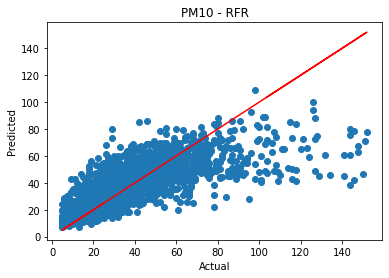

In [ ]:
print(rf_GridSearch.best_params_)
y_pred1=rf_GridSearch.predict(X_valscaled)
score_model(y_val, y_pred1)
y_pred2=rf_GridSearch.predict(X_testscaled)
score_model(y_test, y_pred2)
plt.scatter(y_test, y_pred2)
plt.title('PM10 - RFR')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.plot(y_test, y_test, color = 'red')


In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# Number of trees in random forest
n_estimators = [500]#[int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [45]#[int(x) for x in np.linspace(10, 50, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2]#, 5, 10, 15, 20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2]#, 4, 6, 8, 10]
# Method of selecting samples for training each tree
bootstrap = [True]#, False]
# Create the random grid
grid_para = {'n_estimators': n_estimators,
        'max_features': max_features,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Grid search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_GridSearch=GridSearchCV(rf,param_grid=grid_para, cv=3, return_train_score=True, verbose=2, scoring = 'neg_mean_absolute_error', n_jobs=2)
#rf_random = RandomizedSearchCV(estimator = rf, param_distributions = grid_para, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_GridSearch.fit(X_trainscaled, y_train)
y_pred1=rf_GridSearch.predict(X_valscaled)
score_model(y_val, y_pred1)
y_pred2=rf_GridSearch.predict(X_testscaled)
score_model(y_test, y_pred2)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
R2 score:  0.54, RMSE: 15.54, MAE:  10.09
R2 score:  0.54, RMSE: 15.49, MAE:  10.17


(15.485209706831126, 10.171510904084126)

In [ ]:
joblib.dump(rf_GridSearch, r"d:\msda\data298\model\rfr_best_pm10.joblib")

['d:\\msda\\data298\\model\\rfr_best_pm10.joblib']

### SVR - pm10

In [ ]:
from sklearn.svm import SVR
# pm2.5
C = [0.1, 1, 100, 1000]
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
gamma =['scale', 'auto']
grid_para = {'kernel': kernel, 'C': C, 'gamma':gamma}
svr = SVR()
# Grid search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
svr_GridSearch=GridSearchCV(svr, param_grid=grid_para, cv=3, return_train_score=True, verbose=2, scoring = 'neg_mean_absolute_error', n_jobs=2)
svr_GridSearch.fit(X_trainscaled, y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


GridSearchCV(cv=3, estimator=SVR(), n_jobs=2,
             param_grid={'C': [0.1, 1, 100, 1000], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=2)

{'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
R2 score:  0.45, RMSE: 17.00, MAE:  10.84
R2 score:  0.41, RMSE: 17.56, MAE:  11.20


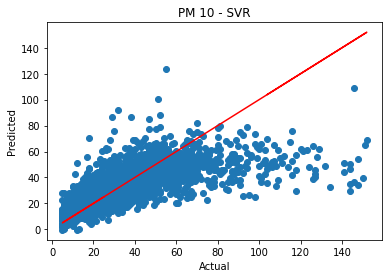

In [ ]:
print(svr_GridSearch.best_params_)

y_pred1 = svr_GridSearch.predict(X_valscaled)
score_model(y_val, y_pred1)
y_pred2 = svr_GridSearch.predict(X_testscaled)
score_model(y_test, y_pred2)
plt.scatter(y_test, y_pred2)
plt.title('PM 10 - SVR')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.plot(y_test, y_test, color = 'red')


In [ ]:
joblib.dump(svr_GridSearch, r"d:\msda\data298\model\svr_best_pm10_1018.joblib")

['d:\\msda\\data298\\model\\svr_best_pm10_1018.joblib']

In [ ]:
regressor = SVR(kernel='rbf', C=10, gamma='scale')
regressor.fit(X_trainscaled,y_train)

### MLP - pm10

In [ ]:
dftmp.describe()

,Arithmetic Mean,AOD047_1,AOD055_1,AOD047_3,AOD055_3,AOD047_5,AOD055_5,NDVI,WIND,TEMP,...,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,LU_30,LU_9
count,3188.000000,3188.000000,3188.000000,3188.000000,3188.000000,3188.000000,3188.000000,3188.000000,3188.000000,3188.000000,...,3188.000000,3188.000000,3188.000000,3188.000000,3188.000000,3188.000000,3188.000000,3188.000000,3188.000000,3188.000000
mean,30.697930,195.237453,177.360100,200.510630,178.065001,196.421945,173.272685,2775.957967,3.803375,68.658030,...,0.085320,0.076537,0.067754,0.069009,0.069950,0.095358,0.099435,0.085947,0.173149,0.806462
std,17.353376,293.281236,293.179448,205.501796,196.422109,171.230783,159.576016,925.117381,2.332400,14.332517,...,0.279401,0.265897,0.251363,0.253509,0.255102,0.293754,0.299293,0.280330,0.378436,0.395133
min,4.000000,-96.000000,-100.000000,0.000000,0.000000,0.000000,0.000000,1407.000000,0.795833,36.445833,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2188.000000,2.283333,57.592708,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,28.000000,108.000000,79.500000,163.666667,130.055556,183.240000,149.760000,2585.000000,3.295833,66.162500,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,39.000000,236.000000,189.250000,298.833333,255.222222,297.420000,256.380000,3178.250000,4.391667,79.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,100.000000,2136.000000,2091.000000,1387.444444,1274.888889,1018.160000,851.240000,8271.000000,22.216667,104.291667,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
seed=42
drop_rate=0.2
init = tf.keras.initializers.GlorotUniform(seed=seed)
def build_reg(unit1,unit2,unit3,unit4,unit5,unit6,unit7):
    ann = tf.keras.models.Sequential()
    ann.add(tf.keras.layers.Dense(input_dim=X_trainscaled.shape[1],units=unit1,kernel_initializer=init, activation='relu'))
    ann.add(Dropout(drop_rate))
    ann.add(tf.keras.layers.Dense(units=unit2,kernel_initializer=init, activation='relu'))
    ann.add(Dropout(drop_rate))
    ann.add(tf.keras.layers.Dense(units=unit3,kernel_initializer=init, activation='relu'))
    ann.add(Dropout(drop_rate))
    ann.add(tf.keras.layers.Dense(units=unit4,kernel_initializer=init, activation='relu'))
    ann.add(Dropout(drop_rate))
    ann.add(tf.keras.layers.Dense(units=unit5,kernel_initializer=init, activation='relu'))
    ann.add(Dropout(drop_rate))
    ann.add(tf.keras.layers.Dense(units=unit6,kernel_initializer=init, activation='relu'))
    ann.add(Dropout(drop_rate))
    ann.add(tf.keras.layers.Dense(units=unit7,kernel_initializer=init, activation='relu'))
    ann.add(tf.keras.layers.Dense(units=1, activation='relu'))
    ann.compile(optimizer = 'adam', loss = 'mean_absolute_error', metrics = ['mae','mse'])
    print(unit1,unit2,unit3,unit4,unit5,unit6,unit7)
    return ann

model=KerasRegressor(build_fn=build_reg)
params={'batch_size':[16],
        'nb_epoch':[100],
        'unit1':[1000,1500,2000,3000,4000,5000],
        'unit2':[1000,1500,2000,3000,4000,5000],
        'unit3':[1000,1500,2000,3000,4000,5000],
        'unit4':[1000,1500,2000,3000,4000,5000],
        'unit5':[1000,1500,2000,3000,4000,5000],
        'unit6':[1000,1500,2000,3000,4000,5000],
        'unit7':[1000,1500,2000,3000,4000,5000],
        }
gs=GridSearchCV(estimator=model, param_grid=params, cv=10)
gs = gs.fit(X_trainscaled, y_train,validation_data=(X_valscaled, y_val))

1000 1000 1000 1000 1000 1000 1000
46/46 [==============================] - 0s 2ms/step - loss: 14.0642 - mae: 14.0642 - mse: 451.4736
1000 1000 1000 1000 1000 1000 1000
46/46 [==============================] - 0s 2ms/step - loss: 13.8137 - mae: 13.8137 - mse: 431.8626
1000 1000 1000 1000 1000 1000 1000
46/46 [==============================] - 0s 2ms/step - loss: 13.6331 - mae: 13.6331 - mse: 355.9985
1000 1000 1000 1000 1000 1000 1000
46/46 [==============================] - 0s 2ms/step - loss: 16.7899 - mae: 16.7899 - mse: 663.0804
1000 1000 1000 1000 1000 1000 1000
46/46 [==============================] - 0s 2ms/step - loss: 14.3094 - mae: 14.3094 - mse: 475.0668
1000 1000 1000 1000 1000 1000 1000
46/46 [==============================] - 0s 2ms/step - loss: 13.1708 - mae: 13.1708 - mse: 374.0374
1000 1000 1000 1000 1000 1000 1000
46/46 [==============================] - 0s 2ms/step - loss: 13.6718 - mae: 13.6718 - mse: 388.0013
1000 1000 1000 1000 1000 1000 1000
46/46 [=============

KeyboardInterrupt: ignored

R2 score:  0.53, RMSE: 15.82, MAE:  10.24
R2 score:  0.49, RMSE: 16.46, MAE:  10.58
R2 score:  0.53, RMSE: 15.82, MAE:  10.24
R2 score:  0.49, RMSE: 16.46, MAE:  10.58


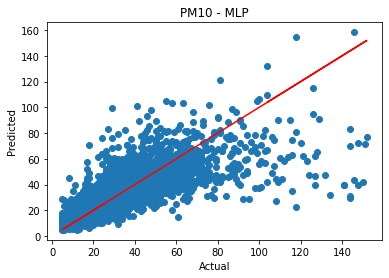

In [ ]:
activation='relu'
init=tf.keras.initializers.GlorotUniform(seed=None)
#2000 3000 5000 1000
model = Sequential()
model.add(Dense(2000, input_dim=X_trainscaled.shape[1], kernel_initializer=init, activation=activation))
model.add(Dropout(0.3))
model.add(Dense(3000, kernel_initializer=init, activation=activation))
model.add(Dropout(0.3))
model.add(Dense(5000, kernel_initializer=init, activation=activation))
model.add(Dropout(0.3))
model.add(Dense(1000, kernel_initializer=init, activation=activation))
model.add(Dense(1))
# Compile model

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
#model.summary()
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_trainscaled, y_train, validation_data=(X_valscaled, y_val),batch_size=32, 
                    epochs=EPOCHS, verbose=0, callbacks=[early_stop])
y_pred1 = model.predict(X_valscaled)
rmse, mae = score_model(y_val, y_pred1)
y_pred2 = model.predict(X_testscaled)
score_model(y_test, y_pred2)

plt.scatter(y_test, y_pred2)
plt.title('PM10 - MLP')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.plot(y_test, y_test, color = 'red')

In [ ]:
model.save(r"d:\msda\data298\model\mlp_best_pm10.h5")

In [107]:
model_saved = tf. keras. models. load_model(r"d:\msda\data298\model\mlp_best_pm10.h5")

R2 score:  0.53, RMSE: 15.76, MAE:  9.99
R2 score:  0.50, RMSE: 16.30, MAE:  10.49


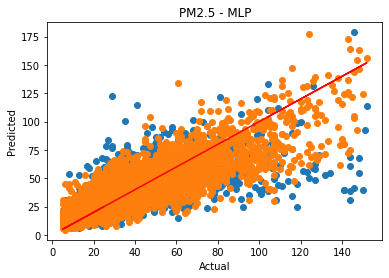

In [108]:
y_pred3 = model_saved.predict(X_trainscaled)
#score_model(y_train, y_pred3)
y_pred1 = model_saved.predict(X_valscaled)
score_model(y_val, y_pred1)
y_pred2 = model_saved.predict(X_testscaled)
score_model(y_test, y_pred2)

#plt.scatter(y_val, y_pred1)
plt.scatter(y_test, y_pred2)
plt.scatter(y_train, y_pred3)
plt.title('PM2.5 - MLP')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.plot(y_test, y_test, color = 'red')

### mlp

In [ ]:
grid_para = {
    'hidden_layer_sizes': [[2000, 2000],[1000,1000],[2000,2000,2000],[1000,2000,1000],[100,1000,100]],
    'activation': ['relu'],
    'solver': ['adam','sgd']}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
reg = MLPRegressor()
mlp_GridSearch = GridSearchCV(estimator = reg, param_grid=grid_para, cv=3, return_train_score=True, verbose=2, scoring = 'neg_mean_absolute_error', n_jobs=-1)
with tf.device('/GPU:0'):
    mlp_GridSearch.fit(X_trainscaled, y_train)
mlp_GridSearch.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\xurui\Anaconda3\envs\gpu38\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [-11.36252922 -13.93049902 -10.97574046 -11.69222914 -11.14226548
          nan -11.23097986          nan -11.64700508 -19.64562151]
  warnings.warn(
C:\Users\xurui\Anaconda3\envs\gpu38\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the train scores are non-finite: [ -7.44743    -11.20918461  -6.62996897  -9.57371194  -4.77380207
          nan  -4.16976705          nan  -4.22323581 -17.95824535]
  warnings.warn(


{'activation': 'relu', 'hidden_layer_sizes': [1000, 1000], 'solver': 'adam'}

{'activation': 'relu', 'hidden_layer_sizes': [1000, 1000], 'solver': 'adam'}
R2 score:  0.43, RMSE: 17.38, MAE:  10.84
R2 score:  0.45, RMSE: 17.05, MAE:  10.96


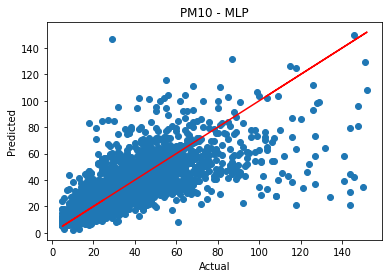

In [ ]:
print(mlp_GridSearch.best_params_)

y_pred1 = mlp_GridSearch.predict(X_valscaled)
score_model(y_val, y_pred1)
y_pred2 = mlp_GridSearch.predict(X_testscaled)
score_model(y_test, y_pred2)
plt.scatter(y_test, y_pred2)
plt.title('PM10 - MLP')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.plot(y_test, y_test, color = 'red')

In [ ]:
joblib.dump(mlp_GridSearch, r"d:\msda\data298\model\mlp_best_pm10_1018.joblib")

['d:\\msda\\data298\\model\\mlp_best_pm10_1018.joblib']

C:\Users\xurui\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


R2 score:  0.40, RMSE: 17.82, MAE:  12.17
R2 score:  0.37, RMSE: 18.19, MAE:  12.31


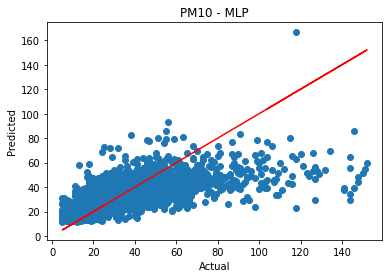

In [ ]:
reg= MLPRegressor(hidden_layer_sizes=([2000, 1000, 2000, 1000]),
        activation="relu", learning_rate = 'adaptive', 
        solver = 'sgd',random_state=1, max_iter=200, early_stop=True).fit(X_trainscaled, y_train)
y_pred1 = reg.predict(X_valscaled)
score_model(y_val, y_pred1)
y_pred2 = reg.predict(X_testscaled)
score_model(y_test, y_pred2)
plt.scatter(y_test, y_pred2)
plt.title('PM10 - MLP')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.plot(y_test, y_test, color = 'red')

R2 score:  0.35, RMSE: 18.55, MAE:  11.63
R2 score:  0.39, RMSE: 17.92, MAE:  11.58


C:\Users\xurui\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


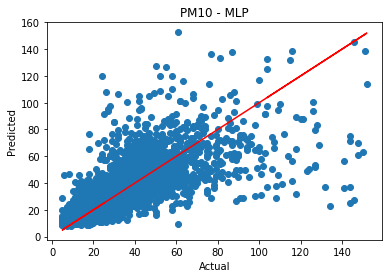

In [ ]:
reg= MLPRegressor(hidden_layer_sizes=([100, 200, 200, 100]),activation="relu", learning_rate = 'adaptive', solver = 'sgd',random_state=1, max_iter=200).fit(X_trainscaled, y_train)
y_pred1 = reg.predict(X_valscaled)
score_model(y_val, y_pred1)
y_pred2 = reg.predict(X_testscaled)
score_model(y_test, y_pred2)
plt.scatter(y_test, y_pred2)
plt.title('PM10 - MLP')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.plot(y_test, y_test, color = 'red')

R2 score:  -24767.66, RMSE: 3617.80, MAE:  3617.73
R2 score:  -24864.13, RMSE: 3618.18, MAE:  3618.10


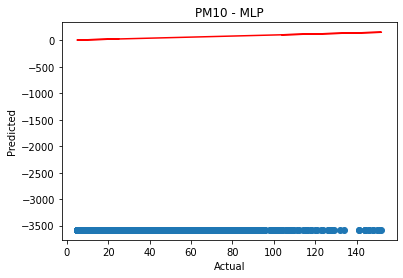

In [ ]:
reg= MLPRegressor(hidden_layer_sizes=([10, 100, 1000, 100, 10]),activation="relu", learning_rate = 'adaptive', solver = 'sgd',random_state=1, max_iter=200).fit(X_trainscaled, y_train)
y_pred1 = reg.predict(X_valscaled)
score_model(y_val, y_pred1)
y_pred2 = reg.predict(X_testscaled)
score_model(y_test, y_pred2)
plt.scatter(y_test, y_pred2)
plt.title('PM10 - MLP')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.plot(y_test, y_test, color = 'red')